In [0]:
# simple generative adversarial network
# this version uses the celebrity faces dataset celeba (aligned)

In [2]:
# mount drive to access csv files

from google.colab import drive

drive.mount('./my_data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./my_data


In [0]:
# conventional PyTorch imports
import torch

import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset

In [0]:
import random
import pandas
import numpy
import matplotlib.pyplot as plt
import h5py

In [5]:
# GPU

#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [6]:
# function to generate uniform random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn(size)

generate_random(5)

tensor([-1.7852, -0.6087, -0.6685, -0.9254,  0.1783])

In [0]:
# crop centre of image, based on https://stackoverflow.com/questions/43463523/center-crop-a-numpy-array

def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx, :]

In [0]:
# crops out 128x128 centre of image

class CelebADataSet(torch.utils.data.Dataset):
    
    def __init__(self, file):
        self.fh = h5py.File(file, 'r')
        self.dataset = self.fh['img_align_celeba']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # image data
        imn = list(self.dataset.keys())[index]
        img = numpy.array(self.dataset[imn])
        # crop square centre
        img = crop_center(img, 128, 128)
        # rescale to (-1, +1)
        img = (img / 127.5) - 1.0
        img = img[::2, ::2, :]
        return torch.cuda.FloatTensor(img)
    
    def plot_image(self, index):
        imn = list(self.dataset.keys())[index]
        img = numpy.array(self.dataset[imn])
        # crop square centre
        img = crop_center(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                idx = random.randint(0,len(celeba_dataset))
                imn = list(self.dataset.keys())[idx]
                img = numpy.array(self.dataset[imn])
                # crop square centre
                img = crop_center(img, 128, 128)
                # resize to 64x64
                img = img[::2, ::2, :] 
                axarr[i,j].imshow(img, interpolation='nearest')
                pass
            pass
        pass
    
    pass

In [0]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data

celeba_dataset = CelebADataSet('my_data/My Drive/Colab Notebooks/gan/celeba_dataset/celeba_aligned_small.h5py')

In [10]:
img = celeba_dataset[0]
print(img.min(), img.mean(), img.max())

tensor(-1.) tensor(0.1374) tensor(1.)


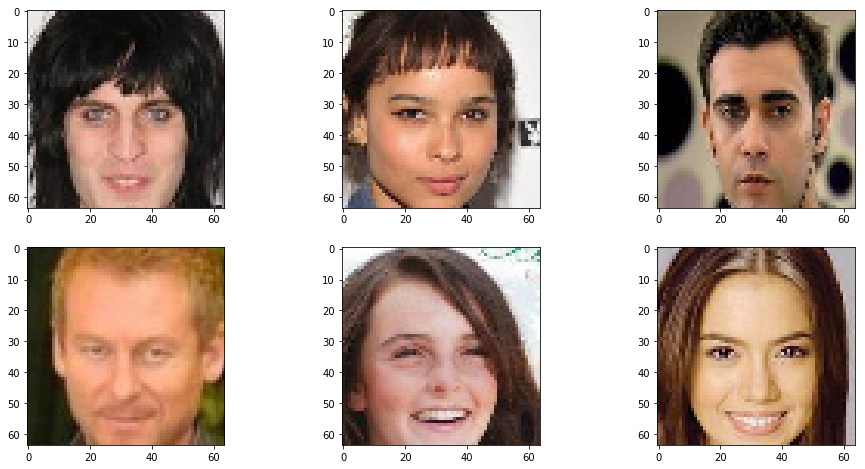

In [11]:
# images are of size cropped to (128,128)

celeba_dataset.plot_images()

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # input shape is 1, 3, 64, 64
        self.model = nn.Sequential(            
            
            nn.Conv2d(3, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 1, kernel_size=4, stride=2, bias=False),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(3),
     
            View((1,1)),
            nn.Sigmoid()
            
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00002, betas=(0.5, 0.999))
        #self.optimiser = torch.optim.RMSprop(self.parameters(), lr=0.0002)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        self.progress.append(loss.item())
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [41]:
# test Discrominator (error messages useful to get convolution sizes right)

D = Discriminator()
D.to(device)
# initialise weights
D.apply(weights_init)

D.forward(generate_random(3*64*64).view(1,3,64,64)).item()

0.5893111228942871

In [17]:
%%time 

# create Discriminator and test it

D = Discriminator()
D.to(device)

# initialise weights
D.apply(weights_init)

# train Discriminator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    count = 1
    for image_data_tensor in celeba_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.permute(2,0,1).view(1, 3, 64, 64), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false (random) data
        D.train(generate_random(3*64*64).view((1, 3, 64, 64)), torch.cuda.FloatTensor([0.0]).view(1,1))
        
        if (count % 1000 == 0):
          print("count = ", count)
          pass
        count += 1
    
        pass
    
    pass


training epoch 1 of 1
count =  1000
count =  2000
count =  3000
count =  4000
count =  5000
count =  6000
count =  7000
count =  8000
count =  9000
count =  10000
count =  11000
count =  12000
count =  13000
count =  14000
count =  15000
count =  16000
count =  17000
count =  18000
count =  19000
CPU times: user 8min 9s, sys: 57.6 s, total: 9min 7s
Wall time: 9min 9s


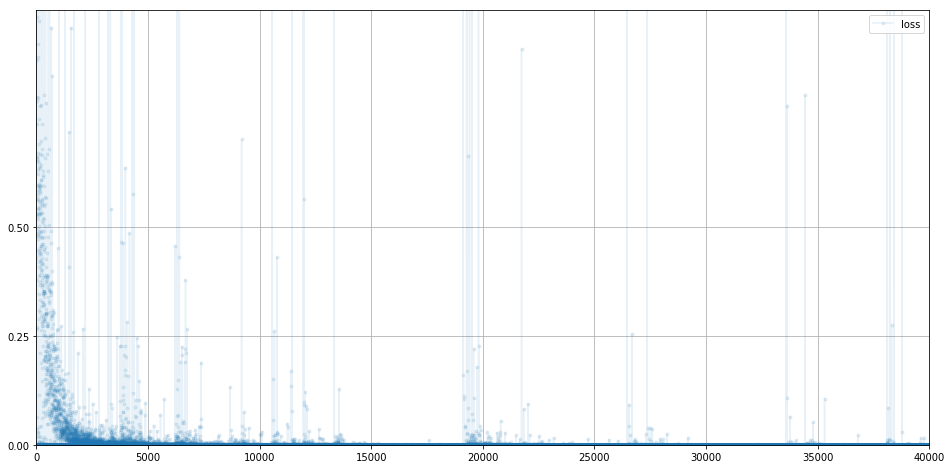

In [18]:
# plot discriminator error

D.plot_progress()

In [20]:
# manually check D can indeed discriminate between real and fake data
for i in range(4):
  print(D.forward(generate_random(3*64*64).view(1, 3, 64, 64)).item())
  pass

print()

for i in range(4):
  print(D.forward(celeba_dataset[random.randint(0,len(celeba_dataset))].permute(2,0,1).view(1, 3, 64, 64)).item())
  pass

8.592582503297308e-07
1.1382971898399319e-08
8.976798540061282e-07
5.1205720552616185e-08

1.0
1.0
1.0
1.0


In [0]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # input shape is 1-dimensional
        self.model = nn.Sequential(
            # reshape seed to tensor
            View((1, 100, 1, 1)),
            
            
            # reshape tensor to 256 filters
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(3),
            
            
            View((1, 3, 64, 64)),
            nn.Tanh()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00002, betas=(0.5, 0.999))
        #self.optimiser = torch.optim.RMSprop(self.parameters(), lr=0.0002)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                img = G.forward(generate_random(100)).view(3,64,64).permute(1,2,0).detach().cpu().numpy()
                img = (img + 1.0) / 2.0
                axarr[i,j].imshow(img, interpolation='none')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 5.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0))
        pass
    
    pass

torch.Size([64, 64, 3])
0.02199027 0.4471252 0.9999908


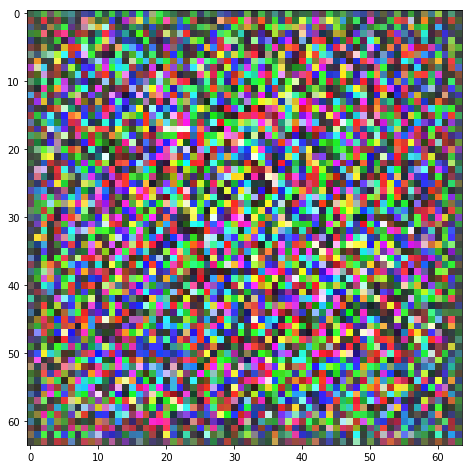

In [64]:
## scratch

G = Generator()
G.to(device)
# initialise weights
G.apply(weights_init)

print(G(generate_random(100)).view(3,64,64).permute(1,2,0).shape)

plt.figure(figsize = (16,8))

img = G.forward(generate_random(100)).view(3,64,64).permute(1,2,0).detach().cpu().numpy()
img = (img + 1.0) / 2.0
print(img.min(), img.mean(), img.max())
plt.imshow(img, interpolation='none')

In [0]:
# create Discriminator and Generator

D = Discriminator()
D.to(device)
# initialise weights
D.apply(weights_init)

G = Generator()
G.to(device)
# initialise weights
G.apply(weights_init)

# free up GPU memory 
torch.cuda.empty_cache()

In [81]:
%%time 

# train Discriminator and Generator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    
    for image_data_tensor in celeba_dataset:
        real = 0.9
        fake = 0.0
        
        if(random.random() < 0.05):
          real = 0.0
          fake = 0.9
          pass
        

        # train discriminator on real data
        D.train(image_data_tensor.permute(2,0,1).view(1, 3, 64, 64), torch.cuda.FloatTensor([real]).view(1,1))
        
        # train discriminator on false
        # use detach() so only D is updated, not G
        # label softening doesn't apply to 0 labels
        D.train(G.forward(generate_random(100)).detach(), torch.cuda.FloatTensor([fake]).view(1,1))
        
        # train generator
        G.train(D, generate_random(100), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        pass
    
    pass


training epoch 1 of 1
counter =  60000
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
CPU times: user 9min 35s, sys: 37.4 s, total: 10min 12s
Wall time: 10min 15s


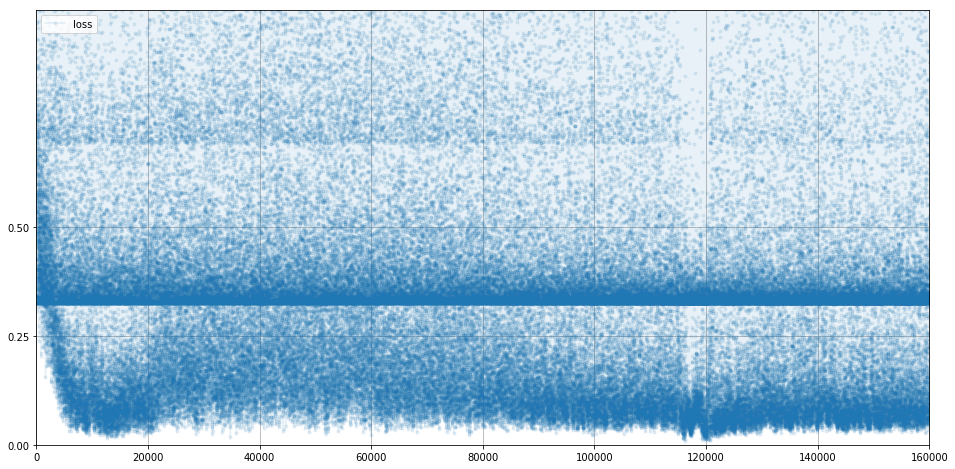

In [82]:
# plot discriminator error

D.plot_progress()

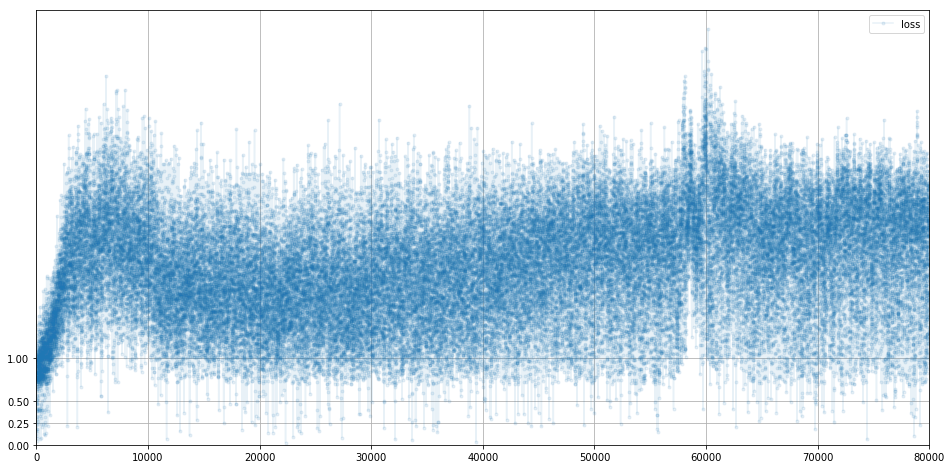

In [83]:
# plot generator error

G.plot_progress()

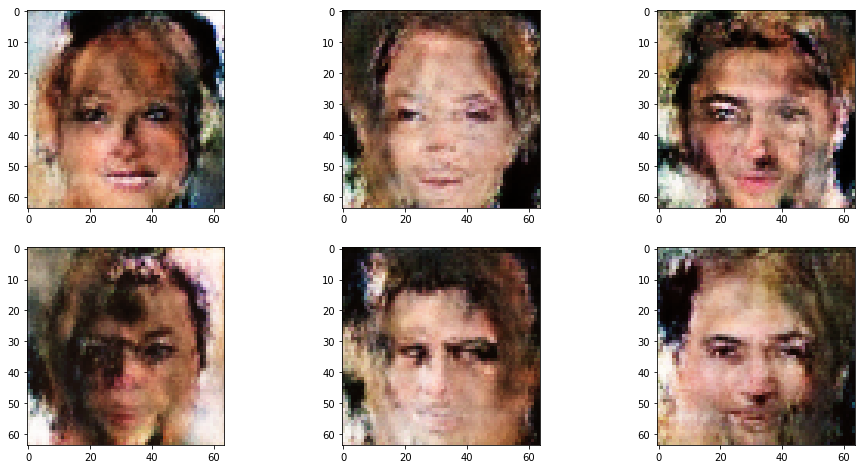

In [94]:
# show generator output

G.plot_images()

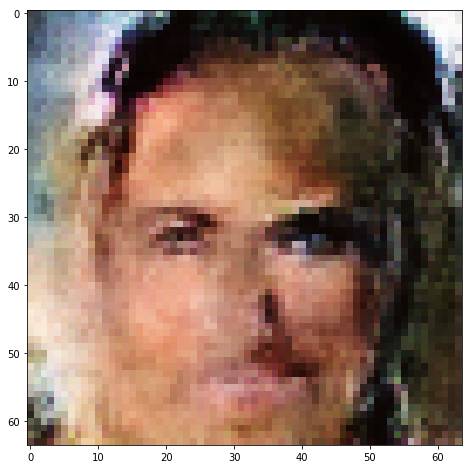

In [91]:
## expts

seed = torch.zeros(100)
seed[random.randint(0,99)] = 1
#seed[80:89] = 1

plt.figure(figsize = (16,8))
img = G.forward(seed).view(3,64,64).permute(1,2,0).detach().cpu().numpy()
img = (img + 1.0) / 2.0
plt.imshow(img, interpolation='none', vmin=0, vmax=1)
